# TASK 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data - Real Gross Domestic Product

### 1. Importing your libraries and data

In [74]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [75]:
# Configure API key 

quandl.ApiConfig.api_key = '5Uw6uXKBE4p1yNa_xU7o'

In [76]:
# Importing the Federal Reserve Economic Data "Real Gross Domestic Product" variable. 
# Relevant as it focuses on economic performance, which connects to the broader research topic for my Achievement project.

data = quandl.get('FRED/GDPC1')

In [77]:
# Looking at the first 5 rows
data.head(5)

,Value
Date,
1947-01-01,2034.450
1947-04-01,2029.024
1947-07-01,2024.834
1947-10-01,2056.508
1948-01-01,2087.442


In [78]:
# Number of rows and columns
data.shape

(300, 1)

In [79]:
# Column names (1)
data.columns

Index(['Value'], dtype='object')

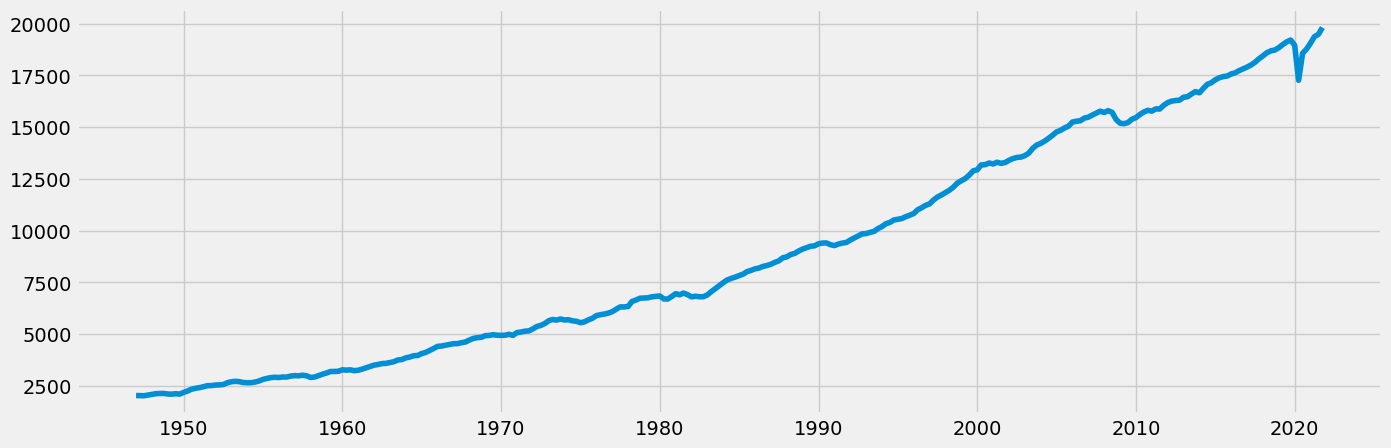

In [80]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if there's a lot of plots.

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [82]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [83]:
data_2.head()

,Date,Value
0,1947-01-01,2034.450
1,1947-04-01,2029.024
2,1947-07-01,2024.834
3,1947-10-01,2056.508
4,1948-01-01,2087.442


In [84]:
# Let's use the data from 2015 - 2019 to go along with the same time frame as the World Happiness Report
data_sub = data_2.loc[(data_2['Date'] >= '2015-01-01') & (data_2['Date'] < '2019-12-31')]

In [85]:
# Number of rows and columns
data_sub.shape

(20, 2)

In [86]:
# First five rows
data_sub.head()

,Date,Value
272,2015-01-01,17280.647
273,2015-04-01,17380.875
274,2015-07-01,17437.080
275,2015-10-01,17462.579
276,2016-01-01,17565.465


In [87]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date"
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2015-01-01,17280.647
2015-04-01,17380.875
2015-07-01,17437.080
2015-10-01,17462.579
2016-01-01,17565.465


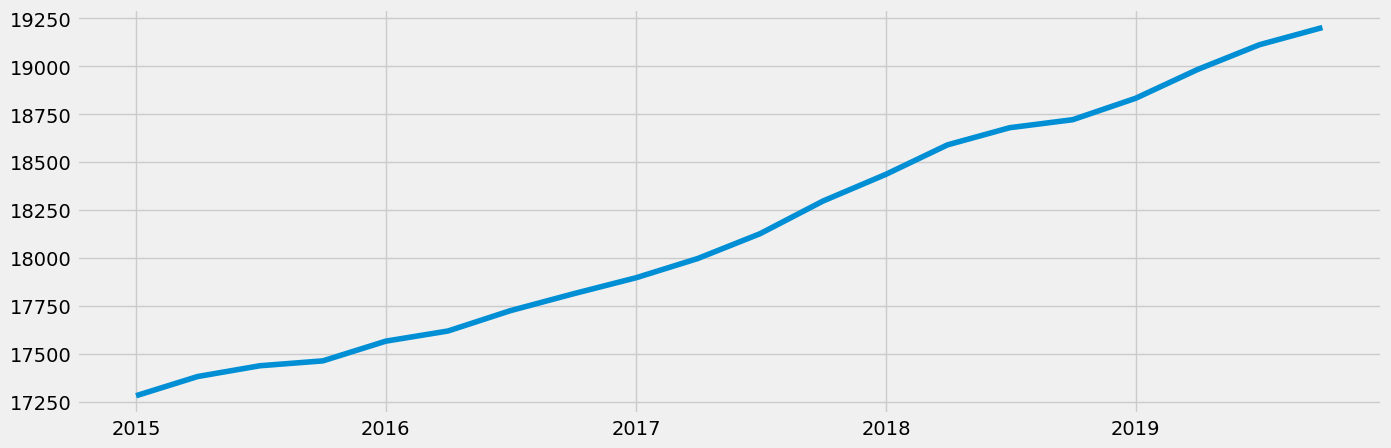

In [88]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [89]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [90]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

### 3. Time-series analysis: decomposition

In [92]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [93]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

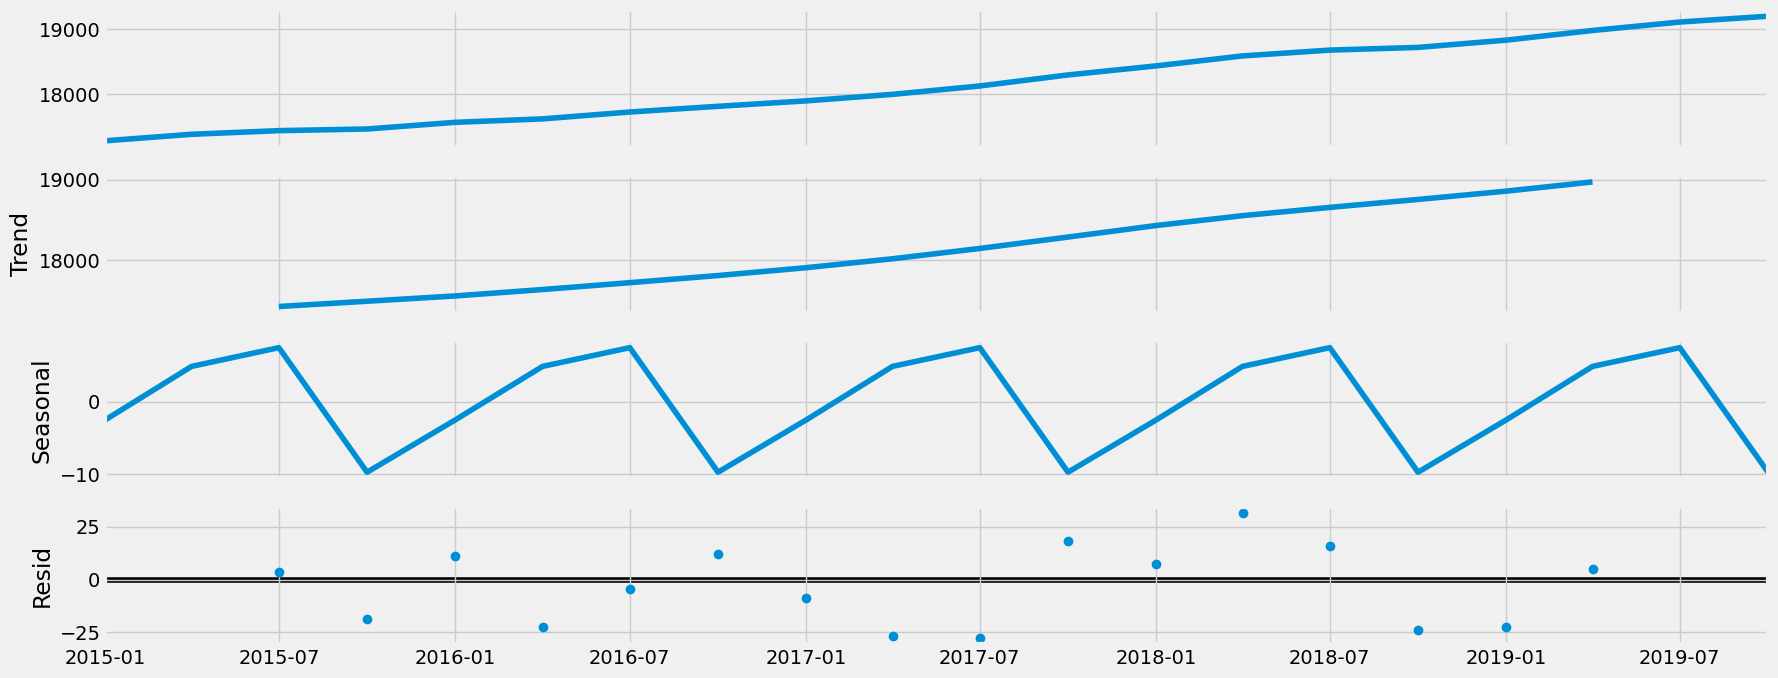

In [94]:
# Plot the separate components

decomposition.plot()
plt.show()

The top chart is called the 'level', it is the data itself.  The next line is the underlying trend. There is a gradual postive upward trend, meaning economic growth during the years of 2015 - 2019. The level and trend are both going in the same upward direction, so the data doesn't have much noise and didn't need to be smoothed.  We can see seasonality (seasonal fluctuations) at a regular interval. Then there is the residual (this is what's left after the trend and seasonanilty have been extracted.  This line is flat, meaning the additive model is a good fit, the dots mean there is a bit of random fluctuation.

### 4. Testing for stationarity

In [97]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -120.753811
p-value                          0.000000
Number of Lags Used              8.000000
Number of Observations Used     11.000000
Critical Value (1%)             -4.223238
Critical Value (5%)             -3.189369
Critical Value (10%)            -2.729839
dtype: float64


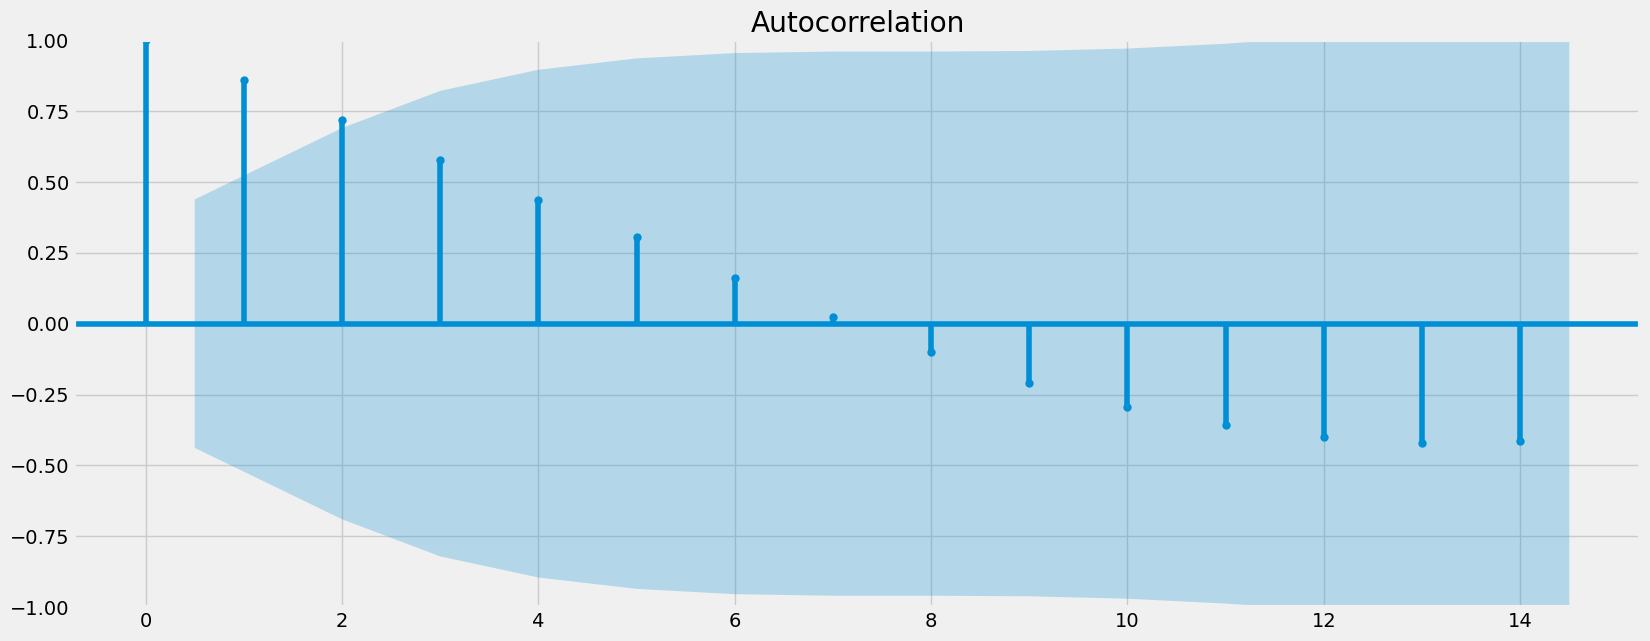

In [98]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

Testing for stationarity using the Dickey-Fuller test... we are looking for the Unit Root.  With a Test Statistic of -120.75 and a Critical Value (5%)  of -3.18, since the test statistic is smaller than the critical value, we reject the null hypothesis. This means we have strong evidence that the series does not have a unit root, meaning it's stationary, making it ideal to forecast the time series. The blue chart above shows the AutoCorrelation (there are only two lags or vertical lines outside of this confidence interval) if there are many, then it would be non-stationary. When lines go outside of the blue edge, it means there are lags that are significantly correlated with each other.

### 5. Stationarizing the Federal Reserve Economic Data - Real Gross Domestic Product

Even tho my data is 'stationary', I wanted to see what the differencing would do to the time-series curve.

In [102]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [103]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [104]:
data_diff.head()

,Value
datetime,
2015-04-01,100.228
2015-07-01,56.205
2015-10-01,25.499
2016-01-01,102.886
2016-04-01,53.116


In [105]:
data_diff.columns

Index(['Value'], dtype='object')

In [106]:
data_diff.shape

(19, 1)

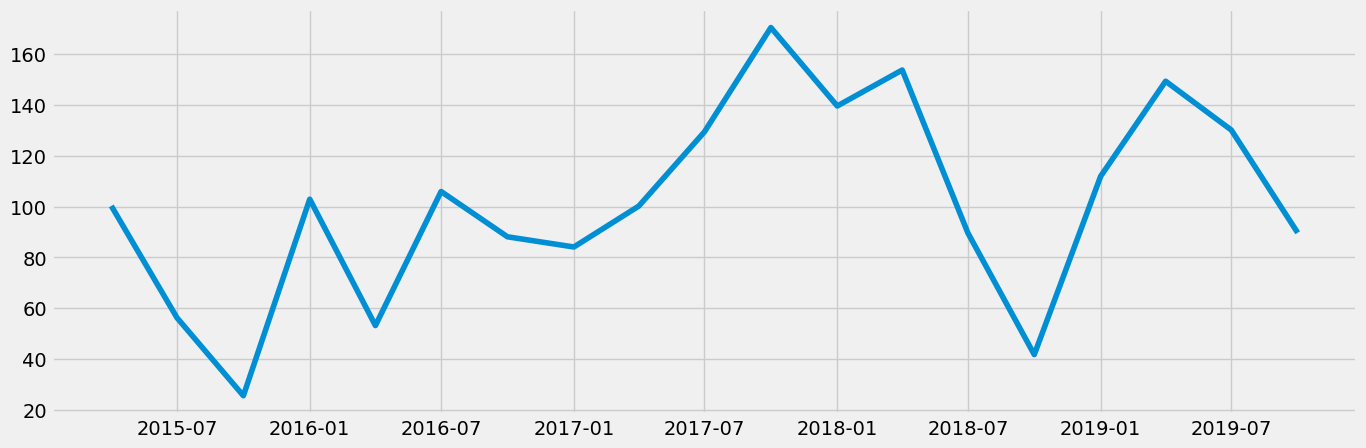

In [107]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [108]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.419490
p-value                         0.000274
Number of Lags Used             7.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


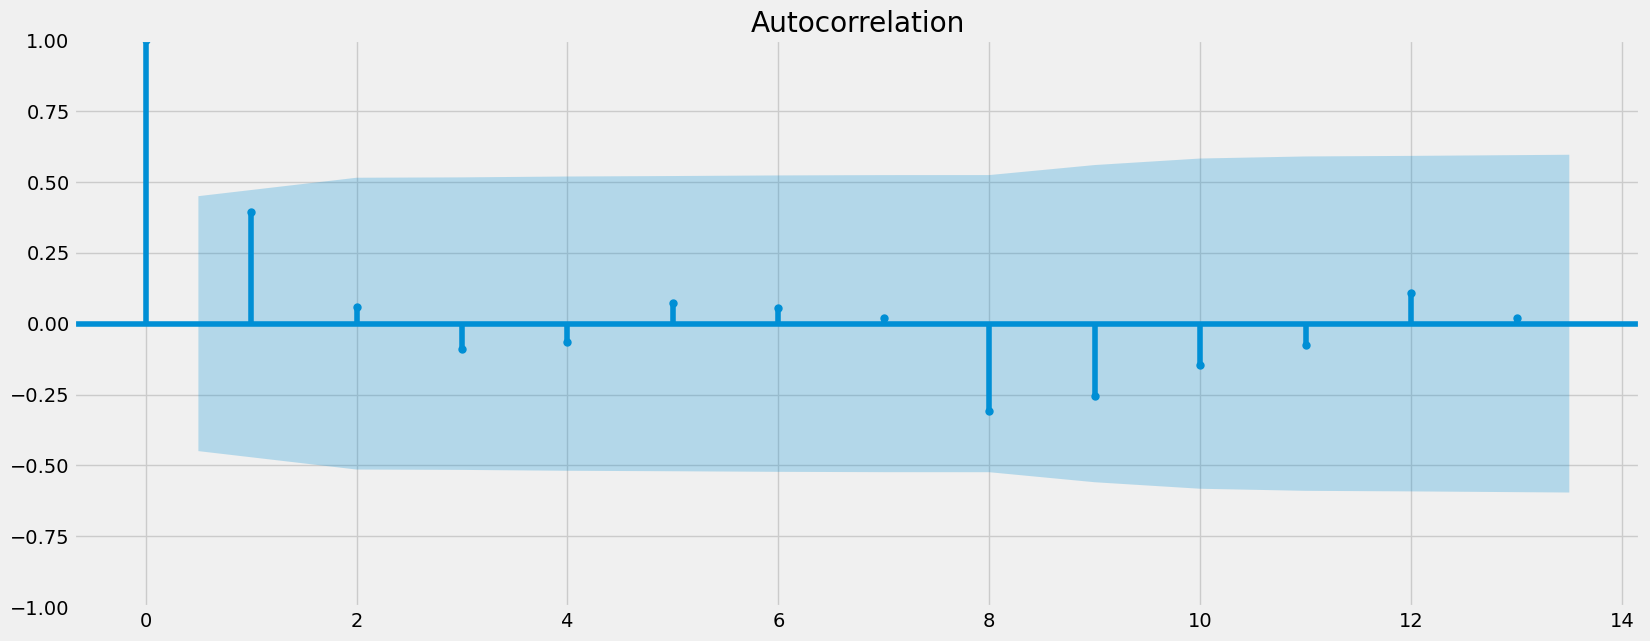

In [109]:
plot_acf(data_diff)
plt.show()

This Dickey-Fuller test has a Test Statistic of -4.41 and a Critical Value (5%) of -3.18.  The test statistic is still lower than the critical value, but not as big of a difference as the first Dickey-Fuller test!  If there are 10 or more significant lags (vertical lines out of the blue zone) then we would do another round of differencing.